In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard library imports
import os
import shutil
import asyncio

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import requests
import urllib3
import pydantic
import geojson
import contextily as ctx

# Geospatial imports
import geopandas as gpd
import osmnx
from shapely.geometry import box
import rasterio
from rasterio.plot import show

# Local/custom module imports
import hoydedata_api
from NVE_FKB_Api import get_sql_db
from resampletif import resample_tif_by_resolution
from Computeflow import compute_flow_acc

In [3]:
# Get drainage basin bounds
# Import geojson & convert to UTM 33 Norway
vassomr = gpd.read_file("./Vector/Vassomr122.geojson")
vassomr = vassomr.to_crs(epsg = 25833)
vassomr.crs

<Projected CRS: EPSG:25833>
Name: ETRS89 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 12°E and 18°E: Austria; Croatia; Denmark - offshore and offshore; Germany - onshore and offshore; Italy - onshore and offshore; Norway including Svalbard - onshore and offshore.
- bounds: (12.0, 34.79, 18.01, 84.01)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [4]:
bounds = vassomr.total_bounds
xmin, ymin, xmax, ymax = bounds
print(xmin, ymin, xmax, ymax)

240389.3999882157 6952336.709914438 335636.93999554525 7048555.489916348


In [5]:
# FKBvann data
# Vi søker etter vassdragsområdenummer 122
FKB_data = get_sql_db(bounds=[xmin, ymin, xmax, ymax], dbname='kart', table='sk.FKB50_VANN_OMRADE',  server='gis-sql04')
FKB_data

,OBJECTID,objtype,lokalid,navnerom,versjonid,datafangstdato,oppdateringsdato,verifiseringsdato,sluttdato,hoyde,registreringsversjon,kystkonstruksjonstype,kystreferanse,medium,vannbredde,regulert,informasjon,eksternpeker,kopidato,geometry
20518,21303025,Elv,ec887a5b-dcb0-4786-8808-e9aa56844f2a,http://data.geonorge.no/SFKB/FKB-Vann/so,2025-05-12 11:16:04.837988000,2024-05-17,2025-11-13 20:11:48,NaT,None,None,2022-01-01,None,None,T,2.0,None,None,None,2026-01-12 07:59:12,"POLYGON ((246076.085 6952336.71, 246076.669 69..."
11545,23233313,Innsjø,a957ae93-ce01-438b-b286-00573507a624,http://data.geonorge.no/SFKB/FKB-Vann/so,2025-05-12 11:16:04.837988000,2024-05-17,2025-11-13 20:11:48,NaT,None,944.15000000,2022-01-01,None,None,T,NaN,Nei,None,None,2026-01-12 07:59:12,"POLYGON ((246371.786 6952537.021, 246371.43 69..."
3898,23234736,Innsjø,6f10a741-d993-4bf0-b3b5-f70be77bb2df,http://data.geonorge.no/SFKB/FKB-Vann/so,2025-05-12 11:16:04.837988000,2014-06-03,2025-11-13 20:11:48,2024-05-17,None,958.77000000,2013-01-01,None,None,T,NaN,Nei,None,None,2026-01-12 07:59:12,"POLYGON ((246537.815 6952840.257, 246537.885 6..."
19372,23234776,Innsjø,f014a9bb-c11a-4729-bd46-5d7a112f1504,http://data.geonorge.no/SFKB/FKB-Vann/so,2025-05-12 11:16:04.837988000,2014-06-03,2025-11-13 20:11:48,2024-05-17,None,959.00000000,2013-01-01,None,None,T,NaN,Nei,None,None,2026-01-12 07:59:12,"POLYGON ((246544.363 6952920.778, 246544.635 6..."
58330,23234780,Innsjø,f99aad78-fc6a-4afa-9fe2-495a4b471489,http://data.geonorge.no/SFKB/FKB-Vann/so,2025-05-12 11:16:04.837988000,2014-06-03,2025-11-13 20:11:48,2024-05-17,None,926.73000000,2013-01-01,None,None,T,NaN,Nei,None,None,2026-01-12 07:59:12,"POLYGON ((245661.167 6952998.193, 245661.395 6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57565,22659608,Innsjø,98ba3a29-3a1e-461f-874f-78fe0d249b2d,http://data.geonorge.no/SFKB/FKB-Vann/so,2023-07-14 13:11:29.994840000,1967-07-01,2025-11-13 18:46:11,2022-09-08,None,381.86000000,None,None,None,T,NaN,Nei,None,None,2026-01-12 07:59:12,"POLYGON ((242688.274 7047066.331, 242689.404 7..."
42001,22671227,Innsjø,0cf1c896-2e0f-4baf-85ff-09fad5e4fcc0,http://data.geonorge.no/SFKB/FKB-Vann/so,2023-07-14 13:11:29.994840000,2022-09-08,2025-11-13 18:47:12,NaT,None,391.03000000,2022-01-01,None,None,T,NaN,Nei,None,None,2026-01-12 07:59:12,"POLYGON ((242574.649 7047172.225, 242572.229 7..."
49794,22659560,Innsjø,6df4656d-1834-4d7a-b477-9a76c85c9f89,http://data.geonorge.no/SFKB/FKB-Vann/so,2023-07-14 13:11:29.994840000,1967-07-01,2025-11-13 18:46:11,2022-09-08,None,169.23000000,None,None,None,T,NaN,Nei,None,None,2026-01-12 07:59:12,"POLYGON ((243388.915 7047884.309, 243385.738 7..."
28178,21218155,Elv,a6cc90ad-fe66-49ae-81e7-c4b282d46287,http://data.geonorge.no/SFKB/FKB-Vann/so,2023-07-14 13:11:29.994840000,2022-09-08,2025-11-13 18:48:40,NaT,None,None,2022-01-01,None,None,T,3.0,None,None,None,2026-01-12 07:59:12,"POLYGON ((241963.779 7048518.798, 241967.86 70..."


In [6]:
type(FKB_data)

geopandas.geodataframe.GeoDataFrame

In [7]:
# First, let's see all unique values in the "objtype" column
unique_objtypes = FKB_data["objtype"].unique()
print("Unique values in 'objtype' column:")
print(unique_objtypes)

Unique values in 'objtype' column:
['Elv' 'Innsjø' 'Kanal' 'Havflate']


In [8]:
# Create a new GeoDataFrame for "Elv" (rivers)
elv_data = FKB_data[FKB_data["objtype"] == "Elv"].copy()
print(f"\nCreated 'elv_data' with {len(elv_data)} features")

# Create a new GeoDataFrame for "Innsjø" (lakes)
innsjo_data = FKB_data[FKB_data["objtype"] == "Innsjø"].copy()
print(f"\nCreated 'innsjo_data' with {len(innsjo_data)} features")

# Optional: Display the first few rows of each new dataset
print("\nSample of elv_data:")
display(elv_data.head())

print("\nSample of innsjo_data:")
display(innsjo_data.head())


Created 'elv_data' with 7789 features

Created 'innsjo_data' with 51037 features

Sample of elv_data:


,OBJECTID,objtype,lokalid,navnerom,versjonid,datafangstdato,oppdateringsdato,verifiseringsdato,sluttdato,hoyde,registreringsversjon,kystkonstruksjonstype,kystreferanse,medium,vannbredde,regulert,informasjon,eksternpeker,kopidato,geometry
20518,21303025,Elv,ec887a5b-dcb0-4786-8808-e9aa56844f2a,http://data.geonorge.no/SFKB/FKB-Vann/so,2025-05-12 11:16:04.837988000,2024-05-17,2025-11-13 20:11:48,NaT,None,None,2022-01-01,None,None,T,2.0,None,None,None,2026-01-12 07:59:12,"POLYGON ((246076.085 6952336.71, 246076.669 69..."
28271,21302912,Elv,e43f827d-e9af-4380-bd38-490e56b0851e,http://data.geonorge.no/SFKB/FKB-Vann/so,2025-05-12 11:16:04.837988000,2024-05-17,2025-11-13 20:11:48,NaT,None,None,2022-01-01,None,None,T,2.0,None,None,None,2026-01-12 07:59:12,"POLYGON ((246088.421 6953827.201, 246088.849 6..."
36067,21302903,Elv,8282d2d7-a553-4296-a2d5-02b9aa811d27,http://data.geonorge.no/SFKB/FKB-Vann/so,2025-05-12 11:16:04.837988000,2024-05-17,2025-11-13 20:11:48,NaT,None,None,2022-01-01,None,None,T,2.0,None,None,None,2026-01-12 07:59:12,"POLYGON ((245770.196 6954427.089, 245769.837 6..."
28279,21303018,Elv,b8a89145-04ce-4fca-a9e2-0f0edc9a74e3,http://data.geonorge.no/SFKB/FKB-Vann/so,2025-05-12 11:16:04.837988000,2024-05-17,2025-11-13 20:11:48,NaT,None,None,2022-01-01,None,None,T,3.0,None,None,None,2026-01-12 07:59:12,"POLYGON ((244416.146 6952552.906, 244416.226 6..."
43878,21303017,Elv,1d25a93c-1527-4949-b801-90a10adf8d13,http://data.geonorge.no/SFKB/FKB-Vann/so,2025-05-12 11:16:04.837988000,2024-05-17,2025-11-13 20:11:48,NaT,None,None,2022-01-01,None,None,T,2.0,None,None,None,2026-01-12 07:59:12,"POLYGON ((244201.814 6952336.71, 244201.908 69..."



Sample of innsjo_data:


,OBJECTID,objtype,lokalid,navnerom,versjonid,datafangstdato,oppdateringsdato,verifiseringsdato,sluttdato,hoyde,registreringsversjon,kystkonstruksjonstype,kystreferanse,medium,vannbredde,regulert,informasjon,eksternpeker,kopidato,geometry
11545,23233313,Innsjø,a957ae93-ce01-438b-b286-00573507a624,http://data.geonorge.no/SFKB/FKB-Vann/so,2025-05-12 11:16:04.837988000,2024-05-17,2025-11-13 20:11:48,NaT,None,944.15000000,2022-01-01,None,None,T,NaN,Nei,None,None,2026-01-12 07:59:12,"POLYGON ((246371.786 6952537.021, 246371.43 69..."
3898,23234736,Innsjø,6f10a741-d993-4bf0-b3b5-f70be77bb2df,http://data.geonorge.no/SFKB/FKB-Vann/so,2025-05-12 11:16:04.837988000,2014-06-03,2025-11-13 20:11:48,2024-05-17,None,958.77000000,2013-01-01,None,None,T,NaN,Nei,None,None,2026-01-12 07:59:12,"POLYGON ((246537.815 6952840.257, 246537.885 6..."
19372,23234776,Innsjø,f014a9bb-c11a-4729-bd46-5d7a112f1504,http://data.geonorge.no/SFKB/FKB-Vann/so,2025-05-12 11:16:04.837988000,2014-06-03,2025-11-13 20:11:48,2024-05-17,None,959.00000000,2013-01-01,None,None,T,NaN,Nei,None,None,2026-01-12 07:59:12,"POLYGON ((246544.363 6952920.778, 246544.635 6..."
58330,23234780,Innsjø,f99aad78-fc6a-4afa-9fe2-495a4b471489,http://data.geonorge.no/SFKB/FKB-Vann/so,2025-05-12 11:16:04.837988000,2014-06-03,2025-11-13 20:11:48,2024-05-17,None,926.73000000,2013-01-01,None,None,T,NaN,Nei,None,None,2026-01-12 07:59:12,"POLYGON ((245661.167 6952998.193, 245661.395 6..."
19367,23234745,Innsjø,8d6057c0-da6e-44b4-9d10-936a4c31cde4,http://data.geonorge.no/SFKB/FKB-Vann/so,2025-05-12 11:16:04.837988000,2014-06-03,2025-11-13 20:11:48,2024-05-17,None,962.95000000,2013-01-01,None,None,T,NaN,Nei,None,None,2026-01-12 07:59:12,"POLYGON ((246478.159 6953027.555, 246477.298 6..."


C:\Users\thob\AppData\Local\Temp\ipykernel_14076\1558420201.py:37: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right')
C:\Users\thob\AppData\Local\Temp\ipykernel_14076\1558420201.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


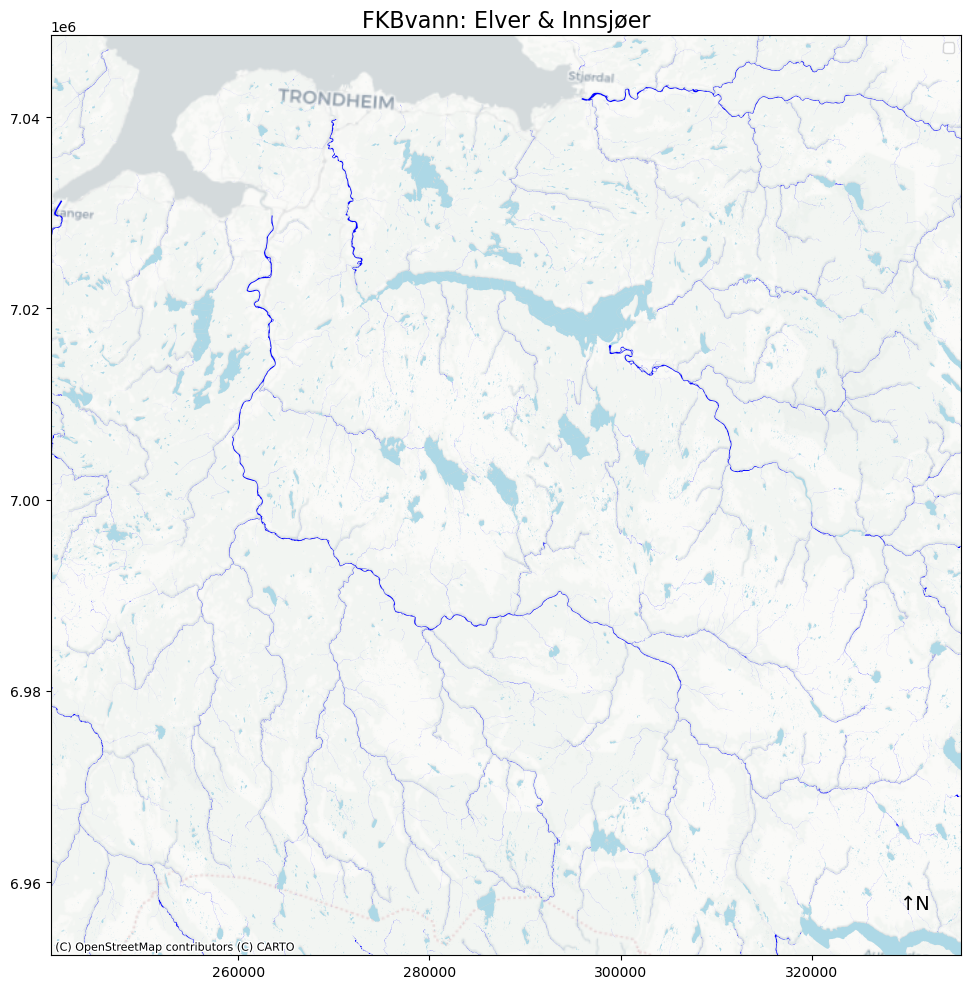

In [9]:
# Assuming bounds or extent coordinates are already defined
# If not explicitly defined, we can extract them from the data
if 'bounds' not in locals():
    xmin, ymin, xmax, ymax = FKB_data.total_bounds
    bounds = (xmin, ymin, xmax, ymax)
else:
    xmin, ymin, xmax, ymax = bounds

# Create a figure with appropriate size
fig, ax = plt.subplots(figsize=(12, 10))

# Create a bounding box for the area of interest
bbox = box(xmin, ymin, xmax, ymax)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:25833")

# Plot the water features with different colors and transparency
elv_data.plot(ax=ax, color='blue', label='Rivers (Elv)')
innsjo_data.plot(ax=ax, color='lightblue', label='Lakes (Innsjø)')

# Convert the bounding box to Web Mercator for basemap
bbox_webmerc = bbox_gdf.to_crs(epsg=3857)

# Add the basemap using contextily
#ctx.add_basemap(ax, crs=elv_data.crs.to_string(), 
#                source=ctx.providers.OpenStreetMap.Mapnik)

# Greyscale version
ctx.add_basemap(ax, crs=elv_data.crs.to_string(),
                source=ctx.providers.CartoDB.Positron)

# Set the extent of the plot to our area of interest
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Add title and legend
ax.set_title('FKBvann: Elver & Innsjøer', fontsize=16)
ax.legend(loc='upper right')

# Add scale bar and north arrow (optional)
ax.text(xmax - (xmax-xmin)*0.05, ymin + (ymax-ymin)*0.05, 
        '↑N', fontsize=14, ha='center')

plt.tight_layout()
plt.show()

In [10]:
## Time to resample the DEM for this, as the 1m is far too large for this process
input_file = "../RAW/NBF_122_Testomraade.tif"
target_res = 10.0
output_dir = "../OUT/"
os.makedirs(output_dir, exist_ok=True)
output_file = f"{output_dir}resampled_area_{int(target_res)}m.tif"

resample_tif_by_resolution(input_file, output_file, target_res)
print("finished")


Resampled TIFF saved to: ../OUT/resampled_area_10m.tif with target resolution 10.0m
finished


In [11]:
## NEED TO ADD IN FUNCTION FOR "WHERE RIVER, BURN 0.5 METRES"

In [12]:
# Calculate flow accumulation
# input_dem = "../OUT/resampled_area_10m.tif"
# out_path =  "../Nedbørfelt/10m_FACC_vd122.tif"

# compute_flow_acc(dem_path=input_dem, path_out=out_path)


In [13]:
with rasterio.open("../Nedbørfelt/10m_FACC_vd122.tif") as src:
    facc_data = src.read(1)  # Read the first band
    transform = src.transform
    crs = src.crs
    bounds = src.bounds
    
    # Print some basic information about the data
    print(f"CRS: {crs}")
    print(f"Shape: {facc_data.shape}")
    print(f"Min value: {facc_data.min()}")
    print(f"Max value: {facc_data.max()}")

CRS: EPSG:25833
Shape: (9621, 9524)
Min value: 1.0
Max value: 6027251.0


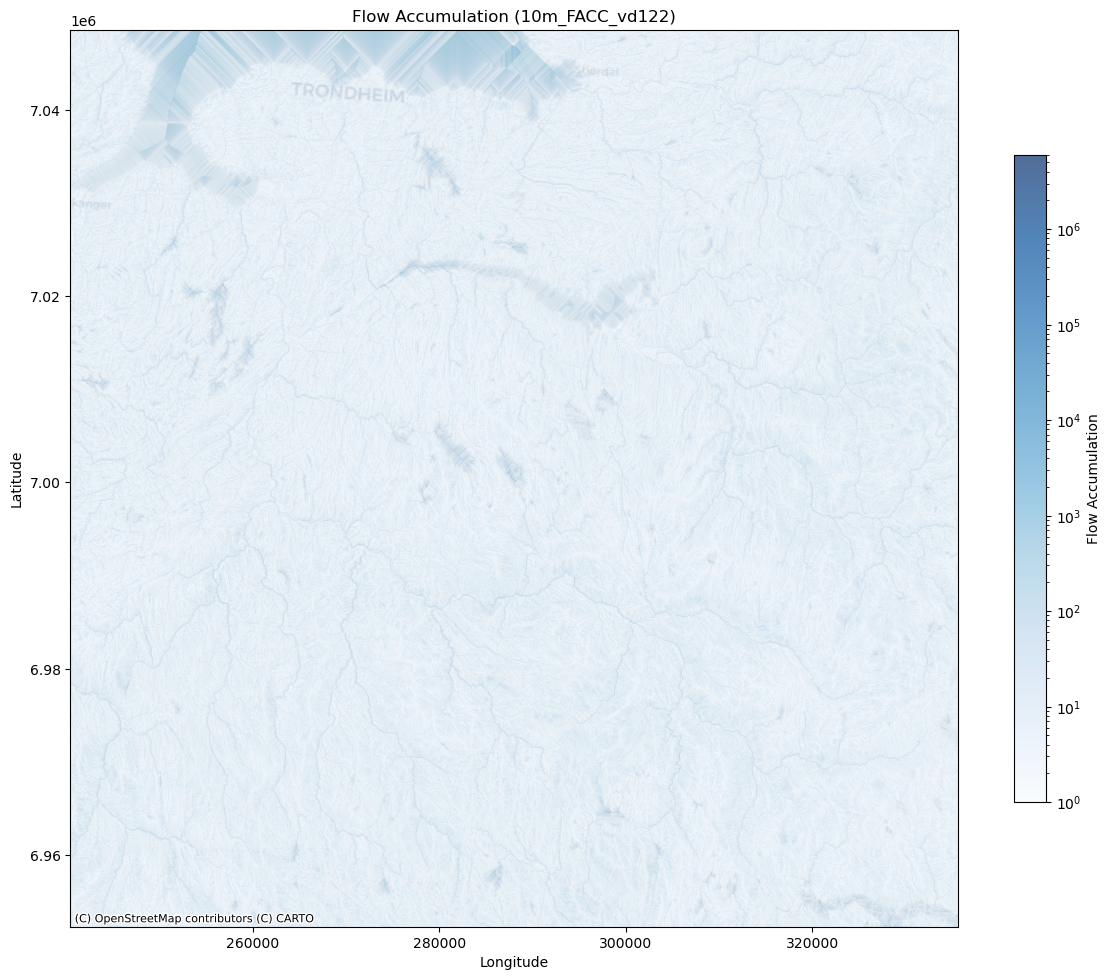

In [14]:
# Create a figure and axis first
fig, ax = plt.subplots(figsize=(12, 10))

# Set the extent of the plot based on the bounds of the data
ax.set_xlim([bounds.left, bounds.right])
ax.set_ylim([bounds.bottom, bounds.top])

# Add the basemap FIRST as the background
try:
    ctx.add_basemap(ax, crs=crs.to_string(), 
                    source=ctx.providers.CartoDB.Positron)
except Exception as e:
    print(f"Could not add basemap: {e}")

# Mask out no-data values (typically negative or very large values)
masked_data = np.ma.masked_where(facc_data <= 0, facc_data)

# Now display the flow accumulation data ON TOP of the basemap
im = ax.imshow(masked_data, 
              extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
              cmap='Blues',
              norm=LogNorm(vmin=max(1, masked_data.min()), vmax=masked_data.max()),
              alpha=0.7)

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label('Flow Accumulation')

# Set title and labels
ax.set_title('Flow Accumulation (10m_FACC_vd122)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Display the plot
plt.tight_layout()
plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio import features
from scipy import ndimage
import contextily as ctx
from shapely.geometry import shape, mapping

In [16]:
# Testing creation of catchment polygons
# read in DTM
dtm_path = "../OUT/resampled_area_10m.tif"  # Update this path to your actual DTM file
with rasterio.open(dtm_path) as src:
    dtm = src.read(1)
    dtm_transform = src.transform
    dtm_crs = src.crs
    dtm_meta = src.meta.copy()

In [17]:
# Step 2: Fill sinks in the DTM to ensure proper flow direction
# This is a simple sink-filling algorithm
filled_dtm = ndimage.gaussian_filter(dtm, sigma=1)  # Smooth to remove small imperfections
filled_dtm = np.maximum(dtm, filled_dtm)  # Take the maximum of original and smoothed

In [18]:
# # Step 3: Calculate flow direction (D8 method - 8 directions)
# # Create arrays for the 8 neighboring cells
# rows, cols = dtm.shape
# dx = [-1, -1, 0, 1, 1, 1, 0, -1]  # x offsets for 8 neighbors
# dy = [0, -1, -1, -1, 0, 1, 1, 1]  # y offsets for 8 neighbors

# # Initialize flow direction array
# flow_dir = np.zeros_like(filled_dtm, dtype=np.int8)

# # Calculate steepest descent for each cell
# for i in range(1, rows-1):
#     for j in range(1, cols-1):
#         center_elev = filled_dtm[i, j]
#         max_drop = 0
#         max_dir = 0
        
#         for d in range(8):
#             ni, nj = i + dy[d], j + dx[d]
#             if 0 <= ni < rows and 0 <= nj < cols:
#                 drop = center_elev - filled_dtm[ni, nj]
#                 if drop > max_drop:
#                     max_drop = drop
#                     max_dir = d + 1  # 1-8 direction coding
        
#         flow_dir[i, j] = max_dir

In [19]:
# Step 3: Calculate flow direction (D8 method) - VECTORIZED VERSION
# Define the 8 neighboring directions
# Order: E, SE, S, SW, W, NW, N, NE (clockwise from East)
d8_rows = np.array([0, 1, 1, 1, 0, -1, -1, -1])
d8_cols = np.array([1, 1, 0, -1, -1, -1, 0, 1])

# Direction values (1-8)
d8_values = np.arange(1, 9)

# Initialize the flow direction array
flow_dir = np.zeros_like(filled_dtm, dtype=np.int8)

# Create a padded version of the DTM to handle edges
padded_dtm = np.pad(filled_dtm, pad_width=1, mode='constant', constant_values=np.inf)

# Calculate elevation drops to all 8 neighbors at once
max_drop = np.zeros_like(filled_dtm, dtype=np.float32)
max_dir = np.zeros_like(filled_dtm, dtype=np.int8)

# For each of the 8 directions
for i in range(8):
    # Get the neighbor's elevation (using the padded array to handle edges)
    neighbor_elev = padded_dtm[1+d8_rows[i]:1+d8_rows[i]+filled_dtm.shape[0], 
                              1+d8_cols[i]:1+d8_cols[i]+filled_dtm.shape[1]]
    
    # Calculate the drop (negative if it's an uphill)
    drop = filled_dtm - neighbor_elev
    
    # Update max_drop and max_dir where this direction has a steeper drop
    mask = drop > max_drop
    max_drop = np.where(mask, drop, max_drop)
    max_dir = np.where(mask, d8_values[i], max_dir)

# Assign the flow direction
flow_dir = max_dir

# Handle flat areas and pits (cells with no downhill neighbors)
# For simplicity, we'll just assign them a default direction (1 = East)
flow_dir[max_drop <= 0] = 0  # 0 can indicate a sink/pit

In [20]:
# Step 4: Use river points as pour points (outlets) for catchment delineation
# Convert river lines to raster
river_mask = np.zeros_like(dtm, dtype=np.uint8)
if 'elv_data' in locals() or 'elv_data' in globals():
    # Rasterize the river lines
    # Remove the 'with' statement since rasterize() returns an array directly
    river_mask = rasterio.features.rasterize(
        [(geom, 1) for geom in elv_data.geometry],
        out_shape=dtm.shape,
        transform=dtm_transform,
        fill=0,
        dtype=np.uint8
    )
else:
    # If elv_data is not available, use the flow accumulation to identify rivers
    # Assuming we have the flow accumulation data from previous code
    if 'facc_data' in locals() or 'facc_data' in globals():
        # Threshold to identify rivers (adjust as needed)
        threshold = np.percentile(facc_data, 99)  # Top 1% of flow accumulation
        river_mask = np.where(facc_data > threshold, 1, 0)

In [21]:
# # Step 5: Delineate catchments using watershed algorithm
# # Label each river segment
# labeled_rivers, num_features = ndimage.label(river_mask)

# # Initialize catchment array
# catchments = np.zeros_like(dtm, dtype=np.int32)

# # For each cell, follow flow direction until reaching a river
# for i in range(1, rows-1):
#     for j in range(1, cols-1):
#         if catchments[i, j] == 0:  # If not already assigned
#             # Trace flow path
#             ci, cj = i, j
#             path = [(ci, cj)]
            
#             while True:
#                 # Check if we've reached a river or already labeled cell
#                 if labeled_rivers[ci, cj] > 0:
#                     # Assign all cells in path to this river's catchment
#                     for pi, pj in path:
#                         catchments[pi, pj] = labeled_rivers[ci, cj]
#                     break
#                 elif catchments[ci, cj] > 0:
#                     # Assign all cells in path to this existing catchment
#                     for pi, pj in path:
#                         catchments[pi, pj] = catchments[ci, cj]
#                     break
                
#                 # Get flow direction
#                 direction = flow_dir[ci, cj]
#                 if direction == 0:  # No outflow (sink or boundary)
#                     break
                
#                 # Move to next cell based on flow direction
#                 d = direction - 1  # Convert back to 0-7 index
#                 ci, cj = ci + dy[d], cj + dx[d]
                
#                 # Check if we're out of bounds
#                 if not (0 <= ci < rows and 0 <= cj < cols):
#                     break
                    
#                 path.append((ci, cj))

In [24]:
# Step 5: Delineate catchments using watershed algorithm - EFFICIENT VERSION

# Ensure we have labeled rivers as markers
if np.sum(river_mask) == 0:
    print("Warning: No river cells identified. Cannot delineate catchments.")
else:
    # Label each river segment
    labeled_rivers, num_features = ndimage.label(river_mask)
    
    print(f"Found {num_features} river segments for catchment delineation")
    
    # Create a cost function based on the inverse of flow direction
    # Higher elevations should have higher costs
    # This ensures water flows downhill in the watershed algorithm
    cost = np.ones_like(filled_dtm, dtype=np.float32)
    
    # Create a mask for the watershed algorithm
    # We'll use the flow direction to create a gradient that guides the watershed
    # First, create an array where each cell points to its downstream neighbor
    rows, cols = flow_dir.shape
    downstream_i = np.zeros_like(flow_dir, dtype=np.int32)
    downstream_j = np.zeros_like(flow_dir, dtype=np.int32)
    
    # Convert flow directions (1-8) to row and column offsets
    for i in range(1, 9):
        mask = (flow_dir == i)
        dir_idx = i - 1  # Convert to 0-7 index
        downstream_i[mask] = d8_rows[dir_idx]
        downstream_j[mask] = d8_cols[dir_idx]
    
    # Create a gradient that increases as we move away from rivers
    # Initialize with a high value
    distance = np.full_like(filled_dtm, 9999999, dtype=np.float32)
    # River cells have distance 0
    distance[labeled_rivers > 0] = 0
    
    # Use a distance transform to create a gradient away from rivers
    # This is much faster than tracing paths
    distance = ndimage.distance_transform_edt(labeled_rivers == 0)
    
    # Use the distance as the cost function
    cost = distance + 1  # Add 1 to avoid zeros
    
    # Apply the watershed algorithm
    # This efficiently assigns each cell to the catchment of the nearest river
    # by following the path of steepest descent
    catchments = ndimage.watershed_ift(
        input=cost.astype(np.uint16),  # Cost function
        markers=labeled_rivers,        # River segments as markers
        structure=np.ones((3, 3))      # 8-connectivity
    )
    
    print("Catchment delineation completed")
    
    # Optional: Fill small holes in catchments
    # Sometimes small areas might not get assigned to any catchment
    if np.any(catchments == 0):
        # Fill holes using nearest-neighbor interpolation
        mask = catchments == 0
        filled_catchments = catchments.copy()
        
        # Use a distance transform to find the nearest non-zero catchment
        indices = ndimage.distance_transform_edt(
            mask, 
            return_distances=False, 
            return_indices=True
        )
        
        # Assign each zero cell to the nearest non-zero catchment
        filled_catchments[mask] = catchments[indices[0][mask], indices[1][mask]]
        catchments = filled_catchments
        
        print("Filled holes in catchments")

Found 92075 river segments for catchment delineation
Catchment delineation completed


In [23]:
# # Step 5: Delineate catchments for segmented rivers - IMPROVED VERSION
# from scipy import ndimage
# import skimage.morphology as morph

# # First, connect nearby river segments that are likely part of the same network
# # Use morphological dilation to connect segments that are close to each other
# connected_rivers = morph.binary_dilation(river_mask, morph.disk(2))
# connected_rivers = morph.binary_erosion(connected_rivers, morph.disk(1))

# # Label the connected river networks
# labeled_networks, num_networks = ndimage.label(connected_rivers)
# print(f"Found {num_networks} river networks after connecting segments")

# # For each network, identify the most downstream point (outlet)
# # This will be our marker for the catchment
# outlets = np.zeros_like(river_mask, dtype=np.int32)

# # Use flow accumulation to identify outlets
# # If we have flow accumulation data (facc_data), we can use it directly
# if 'facc_data' in locals() or 'facc_data' in globals():
#     # For each river network
#     for network_id in range(1, num_networks + 1):
#         # Create a mask for this network
#         network_mask = (labeled_networks == network_id)
        
#         # Find the point with highest flow accumulation (most downstream)
#         if np.any(network_mask):
#             # Get flow accumulation values for this network
#             network_facc = np.where(network_mask, facc_data, 0)
#             # Find the maximum flow accumulation point
#             max_idx = np.argmax(network_facc)
#             max_i, max_j = np.unravel_index(max_idx, facc_data.shape)
#             # Mark this as the outlet
#             outlets[max_i, max_j] = network_id
# else:
#     # If we don't have flow accumulation, use elevation to estimate outlets
#     # For each river network
#     for network_id in range(1, num_networks + 1):
#         # Create a mask for this network
#         network_mask = (labeled_networks == network_id)
        
#         if np.any(network_mask):
#             # Get elevations for this network
#             network_elev = np.where(network_mask, filled_dtm, np.inf)
#             # Find the lowest elevation point (likely the outlet)
#             min_idx = np.argmin(network_elev)
#             min_i, min_j = np.unravel_index(min_idx, filled_dtm.shape)
#             # Mark this as the outlet
#             outlets[min_i, min_j] = network_id

# print(f"Identified {np.sum(outlets > 0)} outlet points for catchment delineation")

# # Now use these outlets as markers for the watershed algorithm
# # Create a cost function based on the inverse of flow direction
# cost = distance + 1  # Using the distance transform from before

# # Apply the watershed algorithm with outlets as markers
# catchments = ndimage.watershed_ift(
#     input=cost.astype(np.uint16),  # Cost function
#     markers=outlets,               # Outlets as markers
#     structure=np.ones((3, 3))      # 8-connectivity
# )

# print("Catchment delineation completed using river network outlets")

C:\Users\thob\AppData\Local\Temp\ipykernel_14076\2823149976.py:7: FutureWarning: `binary_dilation` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.dilation` instead. Note the lack of mirroring for non-symmetric footprints (see docstring notes).
  connected_rivers = morph.binary_dilation(river_mask, morph.disk(2))
C:\Users\thob\AppData\Local\Temp\ipykernel_14076\2823149976.py:8: FutureWarning: `binary_erosion` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.erosion` instead. Note the pixel shift by 1 for even-sized footprints (see docstring notes).
  connected_rivers = morph.binary_erosion(connected_rivers, morph.disk(1))


Found 21690 river networks after connecting segments
Identified 21690 outlet points for catchment delineation


NameError: name 'distance' is not defined

In [25]:
# # Step 6: Convert catchments to vector polygons
# catchment_shapes = []
# for value in range(1, num_features + 1):
#     # Create a mask for this catchment
#     mask = catchments == value
#     if not np.any(mask):
#         continue
        
#     # Convert to shapes
#     shapes = features.shapes(
#         mask.astype(np.uint8),
#         mask=mask,
#         transform=dtm_transform
#     )
    
#     # Get the geometry
#     for geom, val in shapes:
#         if val == 1:
#             catchment_shapes.append(shape(geom))

# # Create a GeoDataFrame from the catchment polygons
# catchment_gdf = gpd.GeoDataFrame(
#     {'id': range(1, len(catchment_shapes) + 1)},
#     geometry=catchment_shapes,
#     crs=dtm_crs
# )


In [26]:
# Step 6: Convert catchments to vector polygons - OPTIMIZED VERSION
import os

# Process all catchments in a single call to features.shapes()
shapes_generator = features.shapes(
    catchments.astype(np.int32),  # Use the catchments array directly
    transform=dtm_transform
)

# Create a dictionary to store geometries by catchment ID
catchment_dict = {}

# Process the shapes
for geom, value in shapes_generator:
    # Skip the background (value 0)
    if value > 0:
        # Convert the GeoJSON geometry to a Shapely geometry
        catchment_dict[int(value)] = shape(geom)

# Create a GeoDataFrame from the dictionary
catchment_gdf = gpd.GeoDataFrame(
    {'id': list(catchment_dict.keys())},
    geometry=list(catchment_dict.values()),
    crs=dtm_crs
)

print(f"Created {len(catchment_gdf)} catchment polygons")

# Create the output directory if it doesn't exist
output_dir = "../Nedbørfelt/"
os.makedirs(output_dir, exist_ok=True)

# Save the catchment GeoDataFrame to the specified location
output_file = os.path.join(output_dir, "Vassdrag122.geojson")
catchment_gdf.to_file(output_file, driver="GeoJSON")
print(f"Saved catchment polygons to {output_file}")

# Also save as shapefile for compatibility with other software
# shp_output = os.path.join(output_dir, "Vassdrag122.shp")
# catchment_gdf.to_file(shp_output, driver="ESRI Shapefile")
# print(f"Saved catchment polygons to {shp_output}")

Created 92075 catchment polygons


2026-02-06 12:48:55,442 - pyogrio._io - INFO - Created 92,075 records


Saved catchment polygons to ../Nedbørfelt/Vassdrag122.geojson


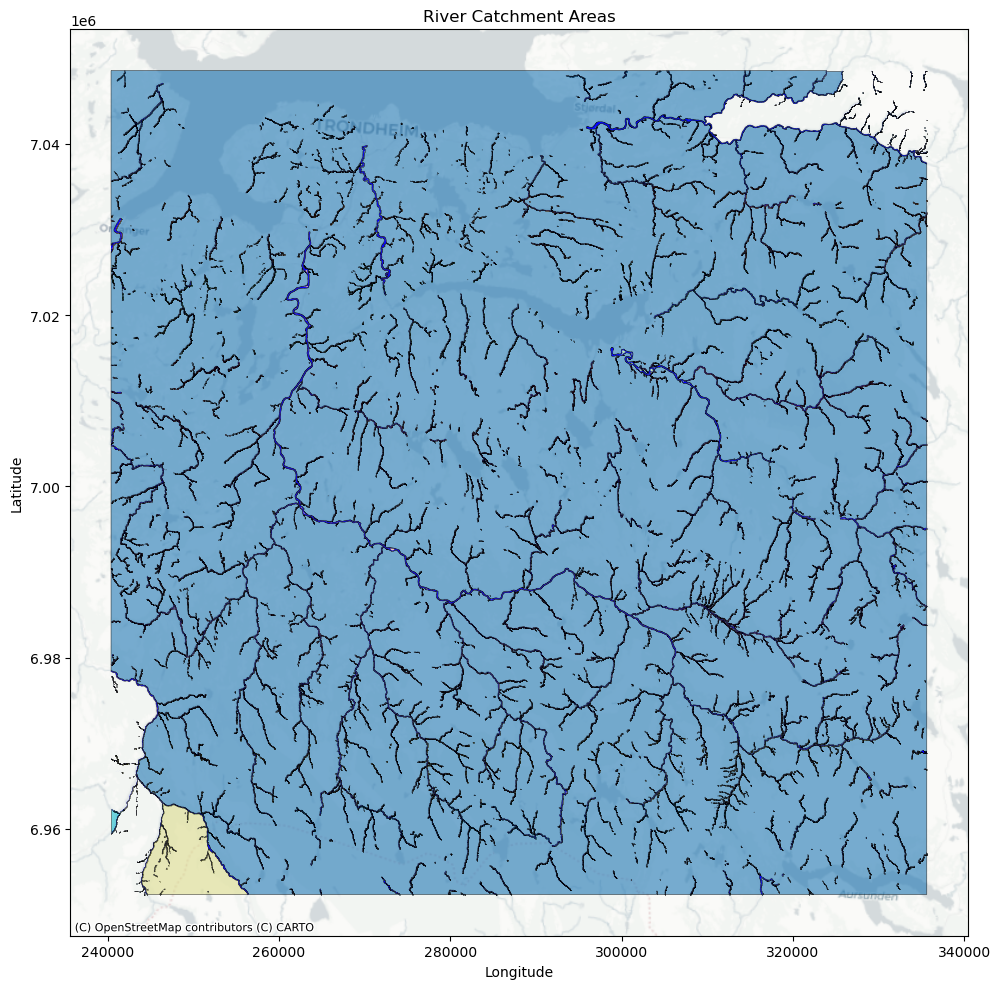

2026-02-06 12:49:34,570 - pyogrio._io - INFO - Created 92,075 records


Catchment areas saved to river_catchments.geojson


In [27]:
# Step 7: Plot the results
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the catchments with random colors
catchment_gdf.plot(
    ax=ax,
    column='id',
    cmap='tab20',
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)

# Plot the rivers on top
if 'elv_data' in locals() or 'elv_data' in globals():
    elv_data.plot(ax=ax, color='blue', linewidth=1)

# Add basemap
ctx.add_basemap(ax, crs=dtm_crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add title and labels
ax.set_title('River Catchment Areas')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

# Save the catchment areas as GeoJSON
catchment_gdf.to_file("../Nedbørfelt/Vassdraget122.geojson", driver="GeoJSON")
print("Catchment areas saved to river_catchments.geojson")